In [39]:
run_name = "comparative_analysis_cpu_50"

Note: this is an **overloaded** setup.

In [40]:
import os
import glob
from functools import reduce

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

## Configuration

1. Httperf
```json
{
    "vms": {
        "base_vm_id": 105,
        "clients": [110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125],
        "type-unused": "NAT",
        "type": {
            "DR": {
                "prefix": "172.17.60.0/24",
                "iface": "eth1"
            }
        }
    },
    "httperf": {
        "vip": "172.17.60.201",
        "port": 80,
        "num-conns": 500,
        "num-calls": 1,
        "rate": 8,
        "ramp": 20,
        "iters": 1,
        "timeout": 3
    }
}
```

2. Host 10.10.10.107:80
```bash
./inf-loop-cpulimit.sh 50 1 # cpulimit=50%
```

## Client side analysis

In [42]:
# read in the data
data_dict = dict()

for d in glob.glob("./results/" + run_name + "/httperf_*_cpu_50"):
    data_list = []
    for i in glob.glob(d + "/httperf_client_*.csv"):
        data_list.append(pd.read_csv(i, header=0, na_filter=False))
    
    data_frame = pd.DataFrame()
    if len(data_list) > 0:
        for i in list(data_list[0]):
            if not i.startswith('Response time'):
                data_frame[i] = reduce(lambda x, y: x + y, [data_list[j][i] for j in range(len(data_list))])
            else:
                data_frame[i] = reduce(lambda x, y: x + y, [data_list[j][i] for j in range(len(data_list))]) / len(data_list)
    data_dict[os.path.basename(d)] = data_frame

In [43]:
for d in data_dict:
    print(d)

httperf_unbalance_wrr_to3_rate_128_cpu_50
httperf_unbalance_wlc_to3_rate_128_cpu_50
httperf_unbalance_wlc_to3_fdb_rate_128_cpu_50
httperf_unbalance_wrr_to3_fdb_rate_128_cpu_50


### 1. Response rate analysis (percentiles)

In [44]:
plot_rrp_unbalance = dict()
plot_rrp_balance = dict()

for d in data_dict:
    if '_unbalance_' in d:
        plot_rrp_unbalance[d] = data_dict[d][['Rate', 'Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%', 'Response rate 80%', 'Response rate 90%', 
         'Response rate 95%', 'Response rate 98%', 'Response rate 99%', 'Response rate 100%']]
    if '_balance_' in d:
        plot_rrp_balance[d] = data_dict[d][['Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%', 'Response rate 80%', 'Response rate 90%', 
         'Response rate 95%', 'Response rate 98%', 'Response rate 99%', 'Response rate 100%']]

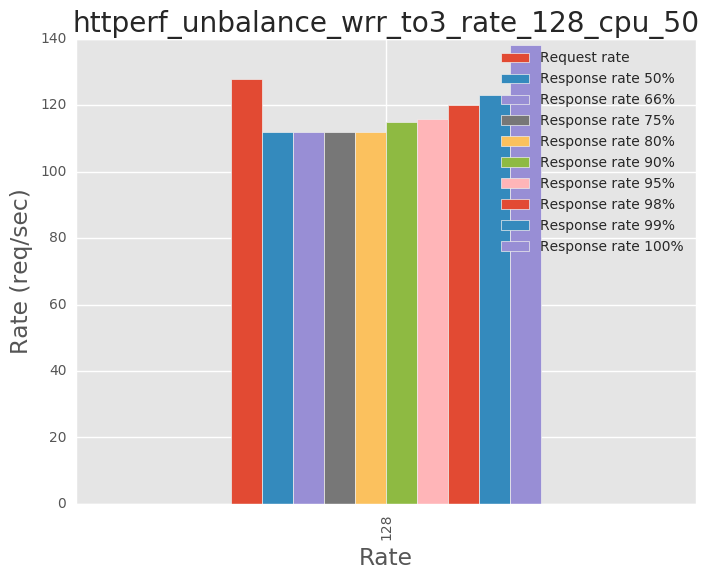

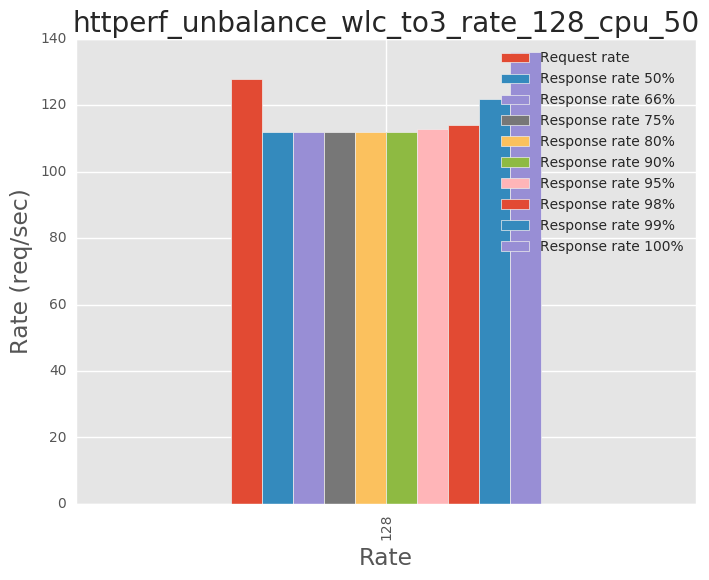

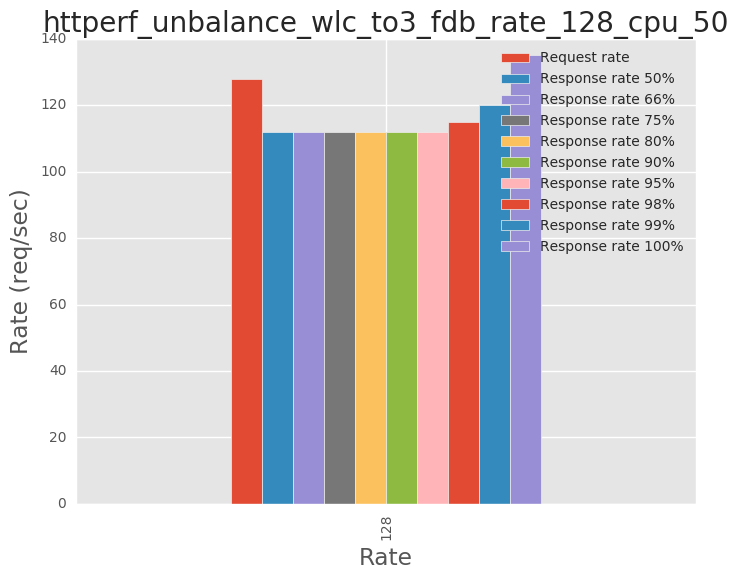

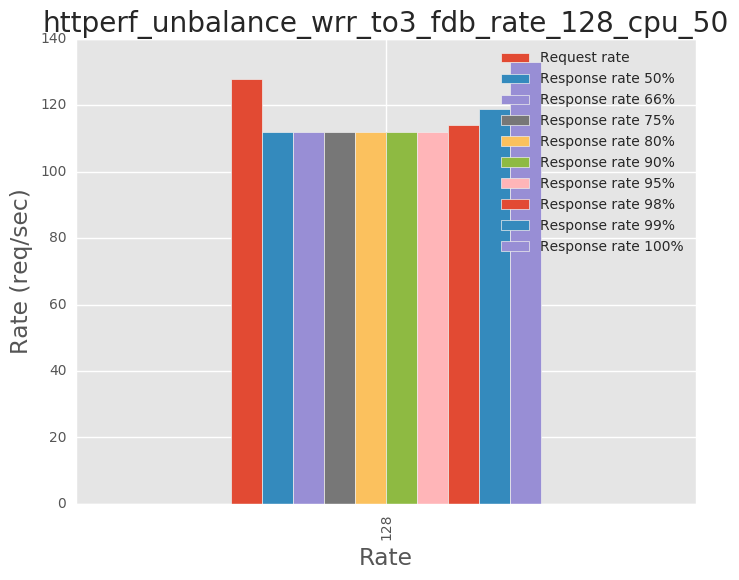

In [45]:
for d in data_dict:
    plot_rrp_unbalance[d].plot('Rate', kind='bar', title=d).set_ylabel('Rate (req/sec)')

### 2. Response time analysis (percentiles)

In [46]:
plot_rtp_unbalance = dict()
plot_rtp_balance = dict()

for d in data_dict:
    if '_unbalance_' in d:
        plot_rtp_unbalance[d] = data_dict[d][['Rate', 'Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%', 'Response time 80%', 'Response time 90%', 
          'Response time 95%', 'Response time 98%', 'Response time 99%', 'Response time 100%']]
    if '_balance_' in d:
        plot_rtp_balance[d] = data_dict[d][['Rate', 'Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%', 'Response time 80%', 'Response time 90%', 
          'Response time 95%', 'Response time 98%', 'Response time 99%', 'Response time 100%']]

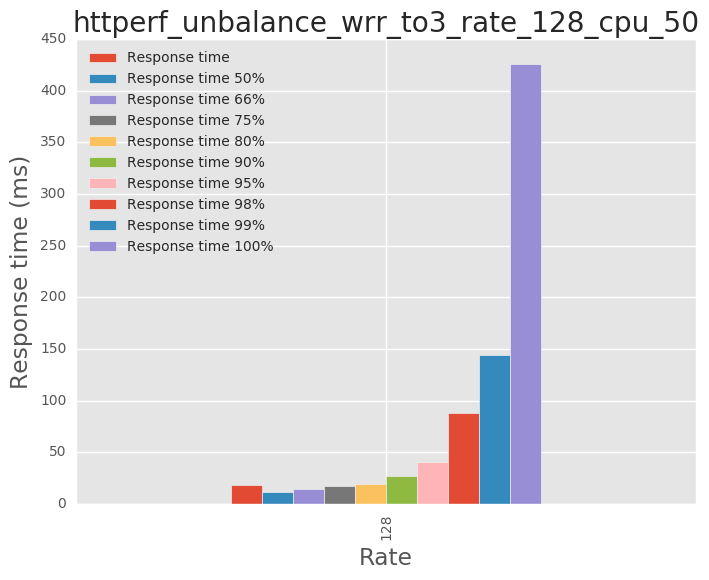

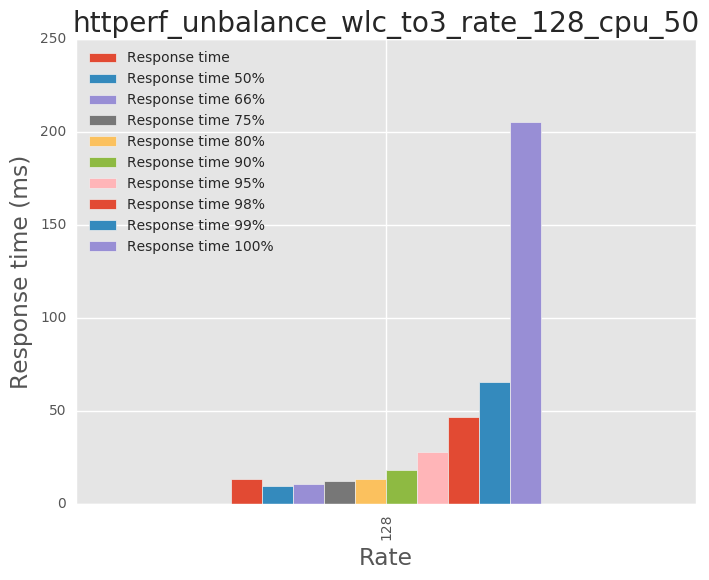

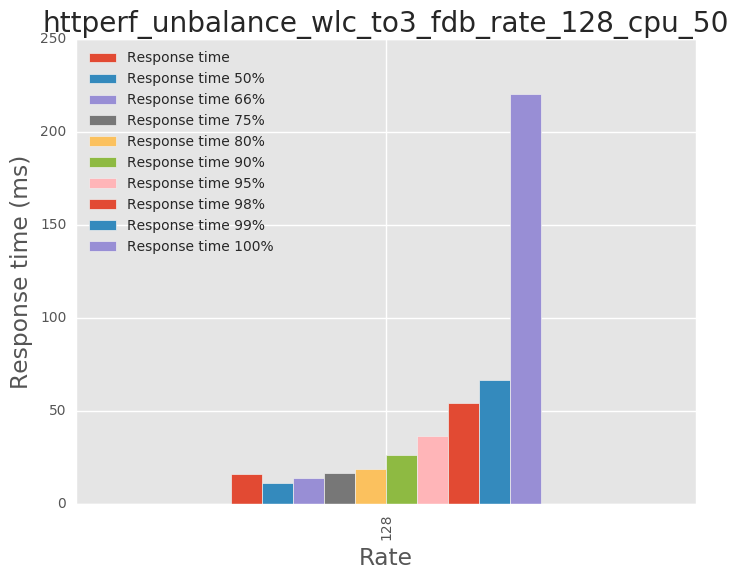

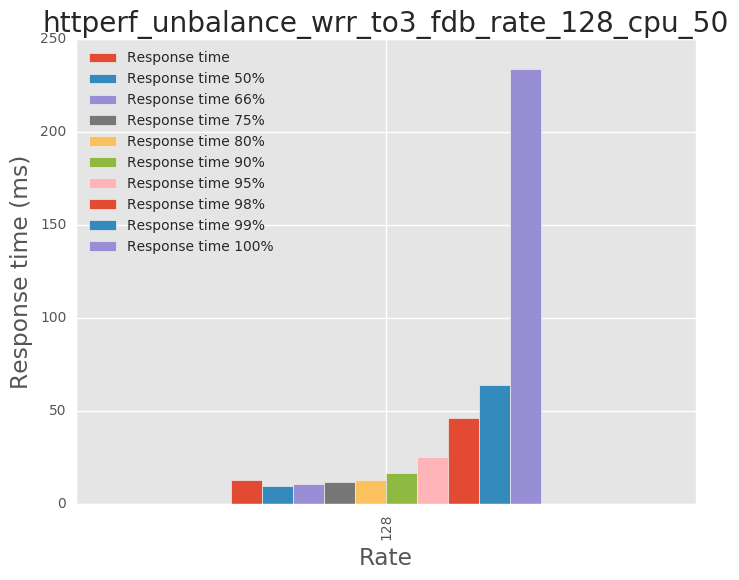

In [47]:
for d in data_dict:
    plot_rtp_unbalance[d].plot('Rate', kind='bar', title=d).set_ylabel('Response time (ms)')

#### WRR comparison chart

In [48]:
plot_rtp_unbalance['httperf_unbalance_wrr_to3_rate_128_cpu_50']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,128,18.41875,11.1875,14.125,17.0,19.3125,27.0,40.375,87.4375,144.375,425.8125


In [49]:
plot_rtp_unbalance['httperf_unbalance_wrr_to3_fdb_rate_128_cpu_50']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,128,12.9875,9.625,10.4375,11.5,12.75,16.6875,25.25,45.9375,63.625,233.625


In [50]:
plot_rtp_unbalance['httperf_unbalance_wrr_to3_fdb_rate_128_cpu_50'] - plot_rtp_unbalance['httperf_unbalance_wrr_to3_rate_128_cpu_50']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,0,-5.43125,-1.5625,-3.6875,-5.5,-6.5625,-10.3125,-15.125,-41.5,-80.75,-192.1875


#### WLC comparison chart

In [51]:
plot_rtp_unbalance['httperf_unbalance_wlc_to3_rate_128_cpu_50']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,128,13.30625,9.5,10.6875,12.125,13.3125,18.0,27.8125,46.625,65.3125,205.125


In [52]:
plot_rtp_unbalance['httperf_unbalance_wlc_to3_fdb_rate_128_cpu_50']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,128,15.8875,11.0,13.875,16.625,18.9375,26.5,36.6875,54.25,66.6875,220.375


In [53]:
plot_rtp_unbalance['httperf_unbalance_wlc_to3_fdb_rate_128_cpu_50'] - plot_rtp_unbalance['httperf_unbalance_wlc_to3_rate_128_cpu_50']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,0,2.58125,1.5,3.1875,4.5,5.625,8.5,8.875,7.625,1.375,15.25


#### WRR-FDB vs. WLC

In [54]:
plot_rtp_unbalance['httperf_unbalance_wrr_to3_fdb_rate_128_cpu_50'] - plot_rtp_unbalance['httperf_unbalance_wlc_to3_rate_128_cpu_50']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,0,-0.31875,0.125,-0.25,-0.625,-0.5625,-1.3125,-2.5625,-0.6875,-1.6875,28.5


In [55]:
plot_rtp_unbalance['httperf_unbalance_wrr_to3_fdb_rate_128_cpu_50'] - plot_rtp_unbalance['httperf_unbalance_wlc_to3_fdb_rate_128_cpu_50']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,0,-2.9,-1.375,-3.4375,-5.125,-6.1875,-9.8125,-11.4375,-8.3125,-3.0625,13.25


### 3. Error analysis

In [56]:
plot_err_unbalance = pd.DataFrame()
plot_err_balance = pd.DataFrame()

for d in data_dict:
    if '_unbalance_' in d:
        plot_err_unbalance[d] = data_dict[d]['Error']
    if '_balance_' in d:
        plot_err_balance[d] = data_dict[d]['Error']
        
if '_unbalance_' in d:
    plot_err_unbalance['Rate'] = data_dict[d]['Rate']
if '_balance_' in d:
    plot_err_balance['Rate'] = data_dict[d]['Rate']

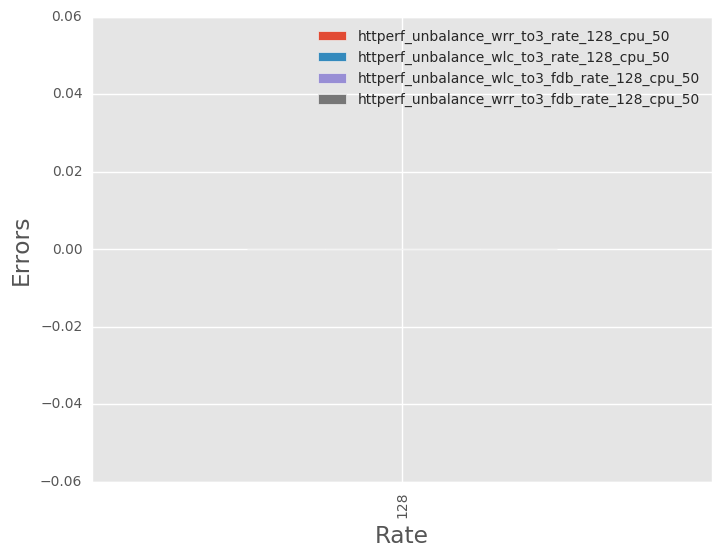

In [58]:
plot_err_unbalance.plot('Rate', kind='bar').set_ylabel('Errors')

## Server side analysis

In [32]:
# read in the data
stats_dict = dict()

for d in glob.glob("./results/" + run_name + "/httperf_*_cpu_50"):
    stats_frame = pd.read_csv(d + "/httperf_server_stats.csv", header=0, na_filter=False)
    for i in ['Connections', 'Packets', 'Bytes (K)']:
        stats_frame[i + ' Ratio (%)'] = stats_frame[i] / sum(stats_frame[i]) * 100
    
    stats_dict[os.path.basename(d)] = stats_frame

### 1. Connections ratio (%)

In [33]:
plot_connections_unbalance = pd.DataFrame()
plot_connections_balance = pd.DataFrame()

plot_connections_unbalance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
plot_connections_balance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
    
for d in stats_dict:
    if '_unbalance_' in d:
        plot_connections_unbalance['Connections Ratio (%) - ' + d] = stats_dict[d]['Connections Ratio (%)']
    if '_balance_' in d:
        plot_connections_balance['Connections Ratio (%) - ' + d] = stats_dict[d]['Connections Ratio (%)']

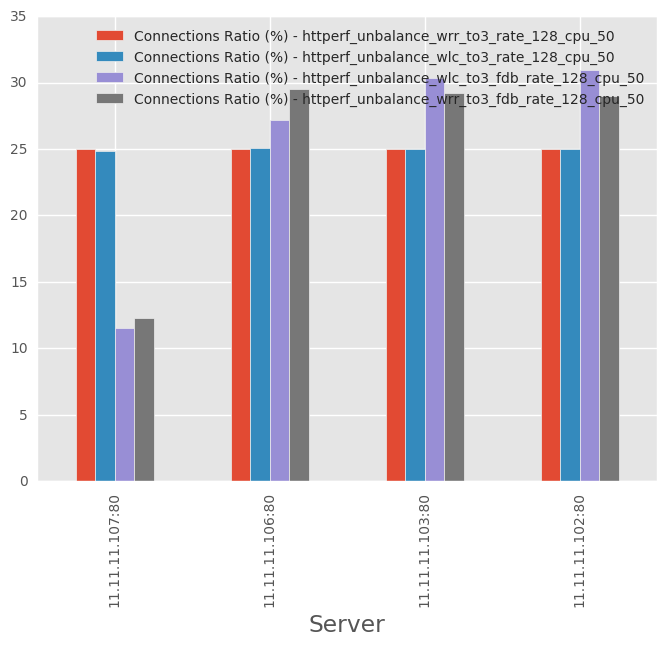

In [34]:
plot_connections_unbalance.plot('Server', kind='bar')

### 2. Packets ratio (%)

In [35]:
plot_packets_unbalance = pd.DataFrame()
plot_packets_balance = pd.DataFrame()

plot_packets_unbalance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
plot_packets_balance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
    
for d in stats_dict:
    if '_unbalance_' in d:
        plot_packets_unbalance['Packets Ratio (%) - ' + d] = stats_dict[d]['Packets Ratio (%)']
    if '_balance_' in d:
        plot_packets_balance['Packets Ratio (%) - ' + d] = stats_dict[d]['Packets Ratio (%)']

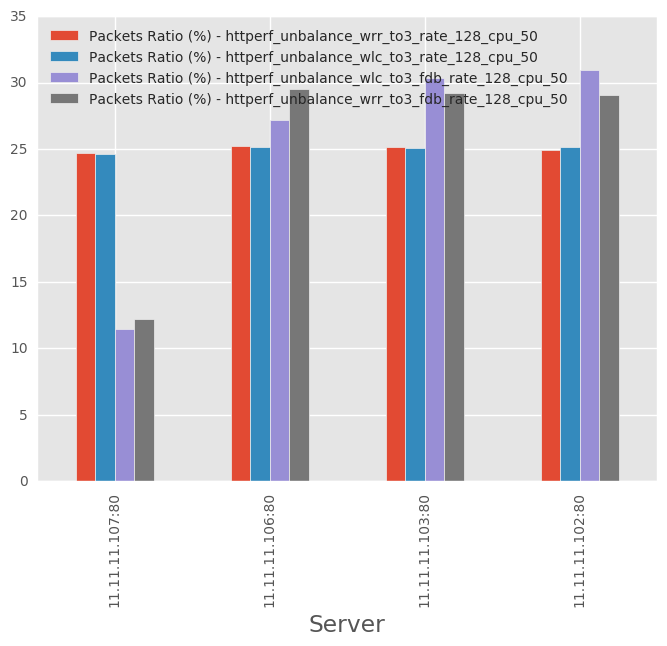

In [36]:
plot_packets_unbalance.plot('Server', kind='bar')

### 3. Bytes ratio (%)

In [37]:
plot_bytes_unbalance = pd.DataFrame()
plot_bytes_balance = pd.DataFrame()

plot_bytes_unbalance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
plot_bytes_balance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
    
for d in stats_dict:
    if '_unbalance_' in d:
        plot_bytes_unbalance['Bytes (K) Ratio (%) - ' + d] = stats_dict[d]['Bytes (K) Ratio (%)']
    if '_balance_' in d:
        plot_bytes_balance['Bytes (K) Ratio (%) - ' + d] = stats_dict[d]['Bytes (K) Ratio (%)']

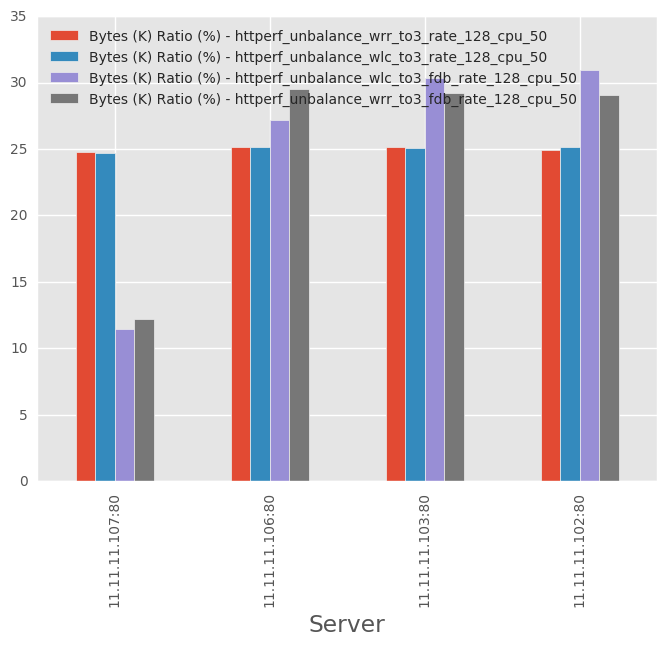

In [38]:
plot_bytes_unbalance.plot('Server', kind='bar')